# A/B-тестирование

Анализируются результаты А/В теста.

**Цель А/В теста**:
Внедрение улучшенной рекомендательной системы с целью улучшения каждой метрики не менее, чем на 10% в течение 14 дней с момента регистрации пользователей


**Ход исследования**:
- Предобработка данных
- Оценка корректности проведения теста
- Исследовательский анализ данных
- Оценка результатов теста

**Техническое задание А/В теста:**

Название теста: `recommender_system_test`

Группы: А (контрольная), B (новая платёжная воронка)

Дата запуска: `2020-12-07`

Дата остановки набора новых пользователей: `2020-12-21`

Дата остановки: `2021-01-04`

Аудитория: 15% новых пользователей из региона EU

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

Ожидаемое количество участников теста: 6000

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
- конверсии в просмотр карточек товаров — событие `product_page`
- просмотры корзины — `product_cart`
- покупки — `purchase`.


## Общая информация

In [58]:
# импорт библиотек 
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import scipy.stats as stats
import warnings
import pylab
import plotly.express as px
from plotly import graph_objects as go
import math as mth
import scipy.stats as st
warnings.filterwarnings('ignore')
register_matplotlib_converters()

In [59]:
# чтение файла
try:
    events = pd.read_csv('/datasets/final_ab_events.csv')
except:
    events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')

In [60]:
# чтение файла
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [61]:
# чтение файла
try:
    users = pd.read_csv('/datasets/final_ab_new_users.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')

In [62]:
# чтение файла
try:
    participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [63]:
def get_info(table):
    """ Функция выводит рандомные 10 строк таблицы и общую информацию по таблице
    
    Она принимает на вход название таблицы
    """
    table.info()#общая информация
    display(table.sample(10))#рандомные 10 строк

In [64]:
get_info(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
245248,982DFC4351DA5CD5,2020-12-28 07:07:55,product_page,NaN
137025,447838073AE4D246,2020-12-10 15:46:23,product_page,NaN
270401,4A7569745B3E507D,2020-12-10 12:59:15,login,NaN
397872,507ABEA60E9CEED9,2020-12-23 20:57:51,login,NaN
297356,575C3CBCAEFCD118,2020-12-14 16:36:04,login,NaN
342706,17893CC3EA3474EE,2020-12-18 06:33:03,login,NaN
140039,025FF5E4C068D8E1,2020-12-11 04:18:18,product_page,NaN
8822,3ADA2133D081A3DA,2020-12-11 20:16:35,purchase,499.99
207017,A62FA46D975B05D0,2020-12-21 14:46:32,product_page,NaN
311126,7EE96EBF3CC535BE,2020-12-15 05:26:32,login,NaN


**Описание данных**

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [65]:
get_info(marketing_events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


**Описание данных**
- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [66]:
get_info(users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
47908,8C819478F2623906,2020-12-12,APAC,Android
49225,E5E9B30C2F43C01E,2020-12-19,EU,Android
54894,1650F5C42843AF51,2020-12-13,EU,Android
25319,9237971D97737528,2020-12-22,N.America,Android
56757,3796AB2EF394DE20,2020-12-13,EU,iPhone
42934,225E72BD156DC921,2020-12-18,EU,Android
39804,708BA4C23A50F3C6,2020-12-11,EU,Android
50033,1A0510704E316536,2020-12-19,EU,iPhone
13385,1D5CFBAD0A524B5C,2020-12-21,CIS,Android
14847,3FD6BEE55BA39ED5,2020-12-21,EU,Android


**Описание данных**
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [67]:
get_info(participants)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
5763,6703B80A2ADCC7C7,A,recommender_system_test
1704,AF330F766D3B2205,B,recommender_system_test
15713,846E57ABF8527672,B,interface_eu_test
9332,552592C48DDE575F,A,interface_eu_test
1130,EBBE8317E9D7B490,B,recommender_system_test
2598,2874E1C3F517893F,B,recommender_system_test
15271,C17F1113553BB04A,A,interface_eu_test
8957,7DF64AF19246381A,A,interface_eu_test
7407,C1899DFB2B114541,B,interface_eu_test
7808,319B40A70C7139F7,B,interface_eu_test


**Описание данных**
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

**Вывод:**

Названия столбцов корректны во всех датафреймах. 


Пропуски встречаются только в таблице **events**, в столбце:`details`. 
    
Тип данных требуется поменять на `date` у всех столбцов с датами:
- `event_dt` - таблица **events**.  
- `start_dt` и `finish_dt` - таблица **marketing_events**. 
- `first_date` - таблица **new_users**

## Предобработка данных

### Изменение типа данных

In [68]:
events['event_dt'] = pd.to_datetime(events['event_dt'])# изменение типа

In [69]:
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])# изменение типа

In [70]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])# изменение типа

In [71]:
users['first_date'] = pd.to_datetime(users['first_date'])# изменение типа

In [72]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


### Обработка дубликатов

In [73]:
events.duplicated().sum()

0

In [74]:
marketing_events.duplicated().sum()

0

In [75]:
users.duplicated().sum()

0

In [76]:
participants.duplicated().sum()

0

Проверим неявные дубликаты. Например, может быть путаница с строчными и прописными буквами

In [77]:
marketing_events['name'].value_counts()

Christmas&New Year Promo            1
St. Valentine's Day Giveaway        1
St. Patric's Day Promo              1
Easter Promo                        1
4th of July Promo                   1
Black Friday Ads Campaign           1
Chinese New Year Promo              1
Labor day (May 1st) Ads Campaign    1
International Women's Day Promo     1
Victory Day CIS (May 9th) Event     1
CIS New Year Gift Lottery           1
Dragon Boat Festival Giveaway       1
Single's Day Gift Promo             1
Chinese Moon Festival               1
Name: name, dtype: int64

In [78]:
users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [79]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

### Обработка пропусков

In [80]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [81]:
# сводная по типу события
events.pivot_table(index='event_name', values='details', aggfunc='count')

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


In [82]:
get_info(events)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
198478,8866F4F079244080,2020-12-20 02:12:21,product_page,NaN
432492,9FD052EE2EAF7724,2020-12-28 23:52:45,login,NaN
145844,D7D4B5FF0AA741B3,2020-12-12 18:08:35,product_page,NaN
169833,A53A88F3D41512CC,2020-12-16 21:37:52,product_page,NaN
432160,EC5CB6F1DE9590AB,2020-12-28 11:00:22,login,NaN
137360,A4D974A73374C3E7,2020-12-10 02:58:38,product_page,NaN
201028,B533DC25BB693DA9,2020-12-20 10:21:29,product_page,NaN
338284,C889BEEF240BF1AC,2020-12-18 03:38:28,login,NaN
140687,F5DE81C5E066FD5D,2020-12-11 18:47:39,product_page,NaN
220480,379D7DFCE16A0CCE,2020-12-23 21:43:15,product_page,NaN


В столбце `details` заполнены только ячейки, относящиеся к типу события: `purchase`. В строках с типом события `purchase` -  пропусков нет. Оставим строки с пропущенными значениями

**Вывод:**
Пропусков и дубликатов нет. Были изменен тип данных столбцов с датами на соответствующий. 

## Оценка корректности проведения теста

### Соответствие данных требованиям технического задания

#### Название теста: recommender_system_test

In [83]:
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В данных пресутсвуют два типа тестов. Отфильтруем таблицу по релевантному тесту

In [84]:
#участники релевантного теста
final_participants = participants.query('ab_test == "recommender_system_test"')

Проверим, есть ли среди участников релевантного теста - те, кто участвовал во 2м тесте датасета.

In [85]:
#участники нерелевантного теста
ir= participants.query('ab_test == "interface_eu_test"')['user_id']

In [86]:
#количество дубль-участников
double_participants = final_participants.query('user_id in @ir')['user_id']
double_participants.shape[0]

1602

Таких пользователей 1602. Посмотрим на разбивку по группам таких пользователей.

In [87]:
#разбивка по группам дубль-участников
final_participants.query('user_id in @double_participants')\
.pivot_table(index='ab_test', columns='group', values='user_id', aggfunc='nunique')

group,A,B
ab_test,,
recommender_system_test,921,681


Дубль-участники распределены относительно равномерно по группам. Поэтому не будем удалять их из датасета.

Также отфильтруем таблицу с информацией о пользователях.

In [88]:
relevant_users = final_participants['user_id']

In [89]:
new_users = users.query('user_id in @relevant_users')

#### Даты запуска и остановки теста

Критерии в ТЗ:
- Дата запуска: 2020-12-07
- Дата остановки набора новых пользователей: 2020-12-21
- Дата остановки: 2021-01-04

In [90]:
# дата запуска
new_users['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [91]:
# дата остановки набора новых пользователей
new_users['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [92]:
# дата запуска
events['event_dt'].min()

Timestamp('2020-12-07 00:00:33')

In [93]:
# дата оставновки
events['event_dt'].max()

Timestamp('2020-12-30 23:36:33')

Фактическая дата остановки на несколько дней раньше заявленной. 

Скорее всего, заявленная дата была получена путем расчетов: 21 декабря (последний день регистрации новых пользователей) + 14 дней.

#### Аудитория: 15% новых пользователей из региона EU

In [94]:
# регионы
new_users['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

In [95]:
# процент новых пользователей из Европы, участвующих в нашем тесте, от всех новых пользователей из Европы
round(100*new_users.query('region=="EU"')['user_id'].nunique()/users.query('region=="EU"')\
      ['user_id'].nunique(),2)

13.73

В тесте участвуют 13.7% новых пользователей из Европы.

Отфильтруем таблицу только по пользователям из Европы согласно ТЗ.

In [96]:
new_users = new_users.query('region=="EU"')

#### Ожидаемый эффект

**ТЗ**: 
За 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%: конверсии в 
- просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

Для того чтобы можно было вычислить конверсию для каждого события и лайфтайм, объединим таблицы между собой.

In [97]:
data = participants.merge(new_users, on='user_id', how='right')
data = data.merge(events, on='user_id', how='left')

In [98]:
data.info()# проверка кол-ва строк после объединения

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32899 entries, 0 to 32898
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     32899 non-null  object        
 1   group       32899 non-null  object        
 2   ab_test     32899 non-null  object        
 3   first_date  32899 non-null  datetime64[ns]
 4   region      32899 non-null  object        
 5   device      32899 non-null  object        
 6   event_dt    29314 non-null  datetime64[ns]
 7   event_name  29314 non-null  object        
 8   details     4044 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.5+ MB


Судя по наличию пропусков в столбцах `event_name` и `event_dt` в данных есть пользователи, которые не совершили ни одного события.
Удалим строки с пропусками, но прежде посмотрим на них поподробнее.

In [99]:
users_without_event = data.loc[data['event_dt'].isna()]# пользователи без событий

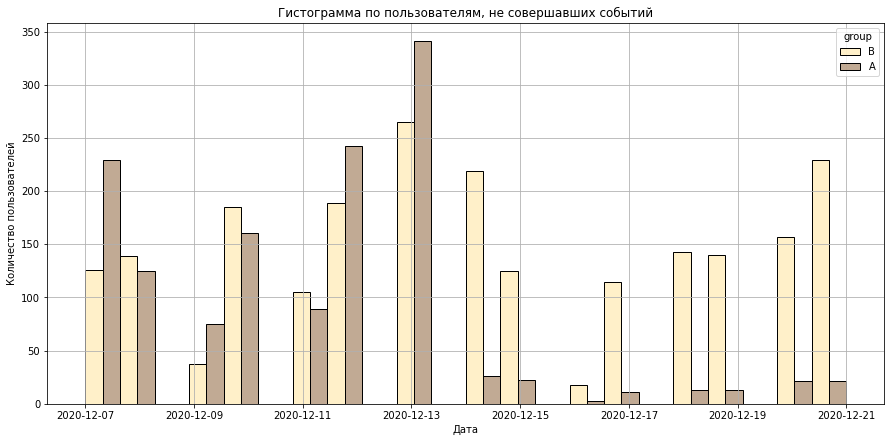

In [100]:
plt.figure(figsize=(15,7))
colors=['#FFEBB7','#AD8E70']
sns.histplot(users_without_event, x='first_date', hue='group', multiple='dodge', palette=colors)

plt.title('Гистограмма по пользователям, не совершавших событий')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid();

После 13 декабря, пользователи без событий практически принадлежали только группе В. В группе А пользователей без событий осталось совсем немного. Возможно, для группы А исправили какие-то ошибки и пользователи начали/смогли совершать события. В группе В все осталось без изменений.

In [101]:
data = data.dropna(subset=['event_dt'])# удаление пропусков

Рассчитаем лайфтайм. 

In [102]:
# добавление колонки lifetime
data['lifetime'] =  (data['event_dt'] - data['first_date']).dt.days

Проверим и исключим события, которые были совершены не в течение 14 дней с момента регистрации.

In [103]:
# удаление строк с лайфтамом >14
data = data.query('lifetime<14').reset_index(drop=True)

Рассчитаем конверсию для каждого события: отношение числа пользователей события к общему числу пользователей.

In [104]:
# сводная таблица с количеством пользователей для каждого события каждой группы
cv = data.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index()
cv

group,event_name,A,B
0,login,2720,1201
1,product_cart,812,340
2,product_page,1747,702
3,purchase,861,348


Порядок событий отличается от порядка, указанного в ТЗ и логики воронки. Сначала пользователь нажимает на карточку товара, а затем уже на корзину.
Необходимо поменять события местами.

In [105]:
# вычисление конверсии для группы А и В
cv['conversion_a'] = round(100*cv['A'] / data.query('group=="A"')['user_id'].nunique(),2)
cv['conversion_b'] = round(100*cv['B'] /  data.query('group=="B"')['user_id'].nunique(),2)
#разница конверсий 
cv['difference'] = cv['conversion_b'] - cv['conversion_a']

# изменение порядка событий
cv = cv.reindex([0, 2, 1, 3]).reset_index(drop=True)
cv

group,event_name,A,B,conversion_a,conversion_b,difference
0,login,2720,1201,100.00,99.92,-0.08
1,product_page,1747,702,64.23,58.40,-5.83
2,product_cart,812,340,29.85,28.29,-1.56
3,purchase,861,348,31.65,28.95,-2.70


Конверсия не улучшилась на ожидаемые 10%, а даже ухудшилась.

### Время проведения теста

Проверим наличие маркетинговых кампаний, которые пересекаются со временем проведения тестирования.

In [106]:
marketing_events.query('(start_dt <= "2020-01-04") or (finish_dt >= "2020-12-07")')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Компания `CIS New Year Gift Lottery` проводится не в Европе. А вот `Christmas&New Year Promo` может повлиять на результаты исследования. Но эта компания проводилась только во 2ю половину периода нашего теста. 

### Аудитория теста

Проверим есть ли пользователи, находящиеся сразу в 2-х группах.

In [107]:
data.pivot_table(index='user_id', columns='ab_test', values='group', aggfunc='nunique').\
query('recommender_system_test==2').count()

ab_test
interface_eu_test          0
recommender_system_test    0
dtype: int64

Пользователей, которые находятся в 2х группах сразу -  нет.

Проверим равномерность распределения пользователей по тестовым группам.

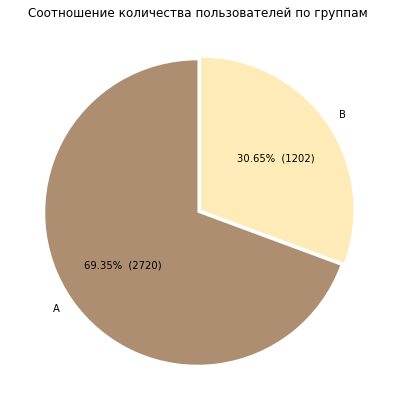

In [108]:
plt.figure(figsize=(7, 7))
explode = (0, 0.03)
valu1 = data.groupby('group')['user_id'].nunique().tolist()
def make_autopct(valu1):
    """ Эта функция позволяет показать на круговой диаграмме относительные и абсолютные значения
    
    Она принимает на вход список из абсолютных значений, по которым строится диаграмма
    """
    def my_autopct(pct):
        total = sum(valu1)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct
data.groupby('group')['user_id'].nunique().\
plot(kind='pie',autopct=make_autopct(valu1),ylabel='',colors=['#AD8E70','#FFEBB7'], explode=explode,\
     startangle=90, title='Cоотношение количества пользователей по группам');

Разделение участников по группам А и В неравномерное. 

Также по графику видно, что в итоге всех итераций у нас осталось всего 3922 пользователей. Проверим достаточного ли этого количества для достоверных результатов. Для этого воспользуемся [калькулятором](https://mindbox.ru/academy/ab-test-calculator/). При среднем показателе в 50% и ожидаемом приросте в 10%, получается, что в каждой группе должно быть не меньше 392 человека. Это условие выполняется. 

**Вывод:**

Данные были отфильтрованы по релевантному тесту, согласно ТЗ: `recommender_system_test`. Есть 1602 пользователей, которые принимали участие в 2х тестах сразу. Они не были удалены, так как равномерно распределены по группам А/В. Скорее всего эти пользователи не могли исказить результаты. 

Фактическая дата остановки на несколько дней раньше заявленной. Дата по ТЗ: 4 января. Фактическая: 30 декабря.

В тесте участвуют 13.7% новых пользователей из Европы. За 14 дней с момента регистрации в системе пользователи не показали улучшение каждой метрики не менее, чем на 10%. Конверсия наоборот ухудшилась.

На результаты могла повлиять маркетинговая кампания: `Christmas&New Year Promo`, проводимая во 2ю половину периода нашего теста. Также разделение участников по группам А и В неравномерное. После фильтрации осталось всего 3922 пользователей, участвующих в тесте. Согласно калькулятору этого достаточно, но все равно уменьшает мощность нашего теста.

## Исследовательский анализ данных

### Распределение количества событий на пользователя

In [109]:
# сводная таблица с расчетом кол-ва событий на пользователя 
events_per_user = data.pivot_table(index=['user_id', 'group'],  values='event_name', aggfunc='count')\
.reset_index()

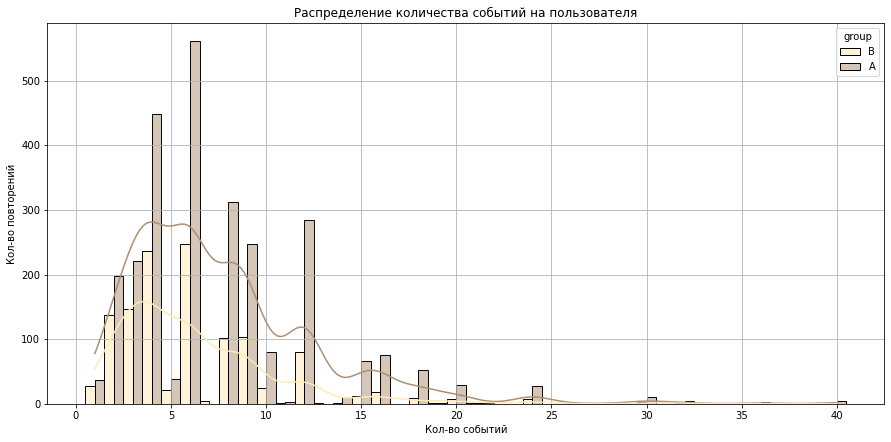

In [110]:
# распределение количества событий на пользователя
plt.figure(figsize=(15,7))
colors=['#FFEBB7','#AD8E70']
sns.histplot(events_per_user, x='event_name', hue='group',discrete=True,palette=colors, kde=True, multiple="dodge")
plt.title("Распределение количества событий на пользователя")
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во повторений')
plt.grid();

In [111]:
# среднее число событий для пользователей группы А
events_per_user.query('group == "A"')['event_name'].mean()

7.634558823529412

In [112]:
# среднее число событий для пользователей группы В
events_per_user.query('group == "B"')['event_name'].mean()

6.286189683860233

Типы распределений числа событий на пользователя одинаковы. Но так как в группе А больше пользователей, то и событий они совершали больше. Среднее число событий на пользователей группы А больше на 1 событие чем у группы В. 

### Распределение количества событий по дням

In [113]:
data['event_dt'] = data['event_dt'].dt.date # изменение типа данных для постройки графика

In [114]:
# сводная таблица с расчетом кол-ва событий по дням
events_per_date = data.pivot_table(index=['event_dt', 'group'],  values='event_name', aggfunc='count')\
.reset_index()

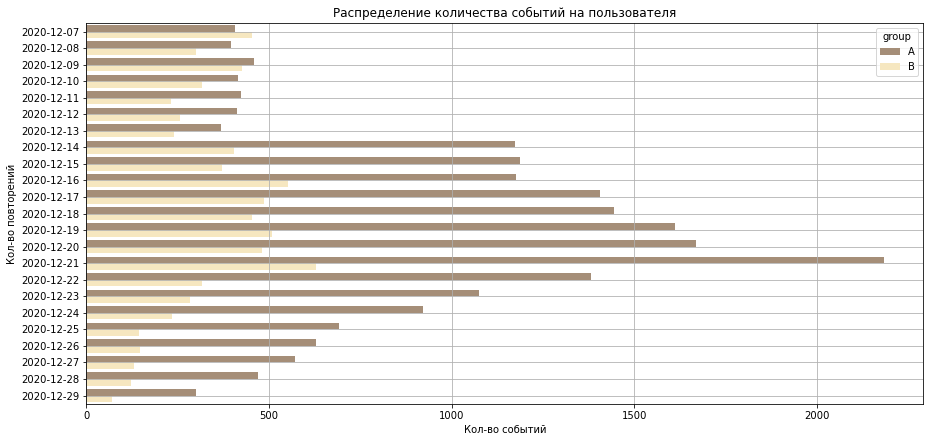

In [115]:
# распределение количества событий на пользователя
plt.figure(figsize=(15,7))
colors=['#AD8E70','#FFEBB7']
sns.barplot(x='event_name', y='event_dt', data = events_per_date, hue='group',palette=colors)
plt.title("Распределение количества событий на пользователя")
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во повторений')
plt.grid();

В группе А с 14 декабря наблюдается резкое увеличение числа событий. 
Максимальное количество событий - 21 декабря.
В группе В всплеска активности пользователей не было.
Выглядит, что рост числа событий группы А связан с отсутствием с 14 декабря пользователей без событий.

### Конверсия в воронке в выборках на разных этапах

Ранее мы уже считали количество конверсию и меняли порядок событий местами.

In [116]:
cv # сводная таблица с количеством пользователей для каждого события каждой группы и конверсией

group,event_name,A,B,conversion_a,conversion_b,difference
0,login,2720,1201,100.00,99.92,-0.08
1,product_page,1747,702,64.23,58.40,-5.83
2,product_cart,812,340,29.85,28.29,-1.56
3,purchase,861,348,31.65,28.95,-2.70


In [122]:
# воронка
#fig = go.Figure()

#fig.add_trace(go.Funnel(
    #name = 'группа А',
    #y = cv['event_name'],
    #x = cv['A'],
    #textinfo = 'value+percent initial', 
    #marker = {"color":'#243763'}))

#fig.add_trace(go.Funnel(
    #name = 'группа В',
    #y = cv['event_name'],
    #x = cv['B'],
    #textinfo = 'value+percent initial',
    #marker = {"color":'#FF6E31'}))

Так как на последнем этапе воронки количество пользователей больше чем на предыдущем, следовательно, есть возможность купить товары в 1 клик. Больше всего пользователей теряется после просмотра карточки товара при переходе в корзину.

**Вывод:**

Типы распределений числа событий на пользователя одинаковы. Но так как в группе А больше пользователей, то и событий они совершали больше. Среднее число событий на пользователей группы А больше на 1 событие чем у группы В. 

В группе А с 14 декабря наблюдается резкое увеличение числа событий. 
Максимальное количество событий - 21 декабря.
В группе В всплеска активности пользователей не было.

Конверсия группы А на всех этапах воронки больше конверсии группы В.

## Оценка результатов A/B-тестирования

Для оценки результатов А/В теста еще раз посчитаем количество пользователей по группам

In [118]:
# пользователи по группам
user_per_gr = data.pivot_table(index='group', values='user_id', aggfunc='nunique').reset_index()
user_per_gr

,group,user_id
0,A,2720
1,B,1202


Количество пользователей по группам и конверсия в разрезе событий: 

In [119]:
cv = cv.query('event_name !="login"') # первое событие убираем, так нет пред. шага
cv

group,event_name,A,B,conversion_a,conversion_b,difference
1,product_page,1747,702,64.23,58.40,-5.83
2,product_cart,812,340,29.85,28.29,-1.56
3,purchase,861,348,31.65,28.95,-2.70


In [120]:
# функция для проверки гипотезы о равенстве долей
def check_rate(event, a):
    alpha = a # критический уровень статистической значимости

    successes_A = np.array(cv[cv['event_name']==event]["A"].values.tolist()[0])
    successes_B = np.array(cv[cv['event_name']==event]["B"].values.tolist()[0])
    trials_A = np.array(user_per_gr[user_per_gr['group']=="A"]['user_id'].values.tolist()[0])
    trials_B = np.array(user_per_gr[user_per_gr['group']=="B"]['user_id'].values.tolist()[0])
     # пропорция успехов в первой группе:
    p1 = successes_A/trials_A

# пропорция успехов во второй группе:
    p2 = successes_B/trials_B

# пропорция успехов в комбинированном датасете:
    p_combined = (successes_A + successes_B) / (trials_A + trials_B)

# разница пропорций в датасетах
    difference = p1 - p2 
# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_A + 1/trials_B))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    print('Событие: {}'.format(event) )
    
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными') 

**Гипотезы** 

Нулевая гипотеза: различий между конверсиями групп нет

Альтернативная гипотеза: различия между конверсией групп есть. 

Так как будет проведено несколько сравнений на одних и тех же данных, то это множественнй тест. Скорректируем уровень значимости методом Бонферрони с целью уменьшения вероятности ошибки первого рода. Всего произведено 3 сравнения.

In [121]:
for event in cv['event_name']:
    check_rate(event, a=0.05/3)

Событие: product_page
p-значение:  0.0005145732643381251
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница
Событие: product_cart
p-значение:  0.3206261339753127
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными
Событие: purchase
p-значение:  0.09105930412098906
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными


**Вывод**

Для событий `product_cart`  и `purchase` нет статистически достоверных отличий между контрольной группой и экспериментальной, даже с учетом поправки Бонферрони. 
Для события `product_page` есть статистически значимая разница между группами теста.


## Итоги

Согласно текущим данным внедрение улучшенной рекомендательной системы не приводит к желаемым результатам. Конверсия группы А на всех этапах воронки больше конверсии группы В. Статистически достоверных отличий между группами А и В нет для  событий `product_cart`  и `purchase`. Для события `product_page` есть статистически значимая разница между группами теста. 

Но согласно исследованию, стоит провести тест заново, так как:
- есть пересечение с конкурирующим тестом
- тест закончился раньше: 30.12.2020
- в тесте участвуют 13.7% новых пользователей из Европы (по ТЗ 15%)
- разделение участников по группам А и В неравномерное: 2720 и 1202 соответственно. Также в группе А с 14 декабря наблюдается резкое увеличение числа событий. В группе В всплесков -  нет.
- всего 3922 участников против 6000
- период проведения  теста пересекается с маркетинговой кампанией `Christmas&New Year Promo`
